In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.formula.api as smf
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt
# from google.colab import drive
# drive.mount('/content/drive')
import re
def tablelize(star):
    string = star.render_latex().replace("\\begin{table}[!htbp] \\centering","").replace("\\end{table}","").replace("_","\\_")
    return re.sub(r"\(df=[\d; ]*\)", "", string)

<Axes: xlabel='distance', ylabel='Count'>

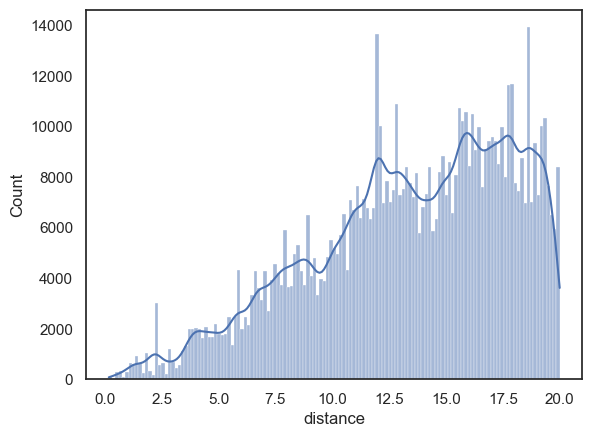

In [3]:
log=np.log
sns.set_theme(style="white")
original_df = pd.read_parquet("../data/olsups.parquet")
sns.histplot(original_df["distance"], kde=True)

In [4]:
df = original_df[original_df["保险金额"] > 0].copy()
df["历史投保"] = df["上年保单号"].map(lambda x: 1 if x else 0)
df = df[(df["t"] > 1999) & (df["t"] < 2014)]
df["ti"] = df["t"].astype(str)
df["是否理赔"] = df["total_claim"].map(lambda x: 1 if x > 0 else 0)
df.rename(
    columns={
        "保费合计": "Premium",
        "保险金额": "Coverage",
        "middle": "Neighbor",
        "treated": "Disaster",
        "after": "Post",
        "历史投保": "Prem_before",
        "保险财产购置价": "Price",
        "建筑面积": "Area",
        "是否理赔":"Claim"
    },
    inplace=True,
)
df["Price"]=df["Price"]/1000000
df.head()

,total_claim,下年保单号,Neighbor,区站号,区站经度,区站纬度,保单号,保单经度,保单纬度,distance,...,Price,Area,t,minpost,maxpost,省份,站名,Prem_before,ti,Claim
1,0.0,,0,58252,119.28,32.11,04FCB12763616712E05400144F67CA43,119.464302,32.190514,19.524547,...,0.241000,137.300003,2004,0.0,0.0,,,0,2004,0
2,0.0,,0,58252,119.28,32.11,04FCB12763626712E05400144F67CA43,119.464302,32.190514,19.524547,...,0.241000,137.300003,2004,0.0,0.0,,,0,2004,0
3,0.0,,0,58027,117.09,34.17,04FCB12763646712E05400144F67CA43,117.194588,34.254807,13.469501,...,0.230646,137.770004,2004,88.0,-281.0,江苏,徐州,0,2004,0
4,0.0,,0,58027,117.09,34.17,04FCB12763666712E05400144F67CA43,117.201012,34.295128,17.255516,...,0.197430,127.320000,2004,88.0,-281.0,江苏,徐州,0,2004,0
6,0.0,,0,58034,118.22,34.37,04FCB127636A6712E05400144F67CA43,118.344032,34.375313,11.398704,...,0.102500,107.000000,2004,0.0,0.0,山东,郯城,0,2004,0


In [5]:
model01 = smf.ols("log(Coverage) ~ Post+Prem_before+Price+Area", data=df).fit()
model01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log(Coverage)   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                 1.683e+04
Date:                Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:59:30   Log-Likelihood:            -8.0286e+05
No. Observations:              531343   AIC:                         1.606e+06
Df Residuals:                  531338   BIC:                         1.606e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      12.1132      0.004   3408.842      0.000      12.106      12.120
Post            0.0327      0.004      8.380      0.000       0.025       0.040
Prem_before     0.5165      0.008     66.944      0.000       0.501       0.532
Price           0.1444      0.001    244.154      0.000       0.143       0.146
Area        -1.368e-11   7.86e-11     -0.174      0.862   -1.68e-10     1.4e-10
==============================================================================
Omnibus:                   487095.922   Durbin-Watson:                   0.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        863089679.477
Skew:                          -3.196   Prob(JB):                         0.00
Kurtosis:                     200.342   Cond. No.                     9.82e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.82e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [6]:
model01 = smf.ols("log(Coverage) ~ Post+Prem_before+Price+Area", data=df[df["Price"]>0]).fit()
raws01 = smf.ols("log(Coverage) ~ Post", data=df[df["Price"]>0]).fit()
stargazer = Stargazer([raws01, model01])
stargazer


In [98]:
with open("../lib/table/ols.tex", "w") as f:
    f.write(tablelize(stargazer))

## DID 回归

### 远vs中

In [7]:
model1 = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+Price+Area", data=df[(df["Disaster"]==0)]).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log(Coverage)   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                 1.219e+04
Date:                Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:59:58   Log-Likelihood:            -6.9309e+05
No. Observations:              463826   AIC:                         1.386e+06
Df Residuals:                  463819   BIC:                         1.386e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.0150      0.004   2756.579      0.000      12.006      12.024
Neighbor          0.2735      0.012     22.352      0.000       0.250       0.297
Post              0.1084      0.005     23.067      0.000       0.099       0.118
Neighbor:Post     0.0375      0.014      2.734      0.006       0.011       0.064
Prem_before       0.5524      0.008     69.866      0.000       0.537       0.568
Price             0.1547      0.001    247.218      0.000       0.153       0.156
Area          -1.205e-11   7.73e-11     -0.156      0.876   -1.64e-10    1.39e-10
==============================================================================
Omnibus:                   465843.458   Durbin-Watson:                   0.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1102628961.613
Skew:                          -3.755   Prob(JB):                         0.00
Kurtosis:                     241.742   Cond. No.                     2.33e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
raws1 = smf.ols("log(Coverage) ~ Neighbor*Post", data=df[(df["Disaster"]==0)]).fit()
stargazer = Stargazer([raws1, model1])
stargazer


In [102]:
with open("../lib/table/did1.tex", "w") as f:
    f.write(tablelize(stargazer))

### 远vs近

In [9]:
model2 = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+Price+Area", data=df[(df["Neighbor"]==0)]).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          log(Coverage)   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.116
Method:                 Least Squares   F-statistic:                 1.071e+04
Date:                Sun, 28 Apr 2024   Prob (F-statistic):               0.00
Time:                        20:00:16   Log-Likelihood:            -7.4123e+05
No. Observations:              489504   AIC:                         1.482e+06
Df Residuals:                  489497   BIC:                         1.483e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.0194      0.004   2703.396      0.000      12.011      12.028
Disaster          0.2513      0.008     30.725      0.000       0.235       0.267
Post              0.1100      0.005     22.954      0.000       0.101       0.119
Disaster:Post    -0.3459      0.010    -34.749      0.000      -0.365      -0.326
Prem_before       0.5568      0.008     68.759      0.000       0.541       0.573
Price             0.1452      0.001    234.149      0.000       0.144       0.146
Area          -1.231e-11   7.88e-11     -0.156      0.876   -1.67e-10    1.42e-10
==============================================================================
Omnibus:                   465499.399   Durbin-Watson:                   0.901
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        936737924.557
Skew:                          -3.404   Prob(JB):                         0.00
Kurtosis:                     217.199   Cond. No.                     1.63e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
raws2 = smf.ols("log(Coverage) ~ Disaster*Post", data=df[(df["Neighbor"]==0)]).fit()
stargazer = Stargazer([raws2, model2])
stargazer


In [105]:
with open("../lib/table/did2.tex", "w") as f:
    f.write(tablelize(stargazer))

## 描述性统计

In [24]:
descol=["Coverage","Disaster","Neighbor","Post","Prem_before","Price","Area"]
todesc=df[descol].astype(float).describe()
todesc=todesc.astype(int).astype(str).T.rename(columns={"50%":"median"})
with open("../lib/table/desc.tex", "w") as f:
    print(todesc[['count', 'mean', 'std', 'min', 'median', 'max']].to_latex().replace("_","\\_"), file=f)
with open("../lib/table/corr.tex", "w") as f:
    print(df[descol].corr().to_latex().replace("_","\\_"), file=f)

<Axes: xlabel='Coverage', ylabel='Count'>

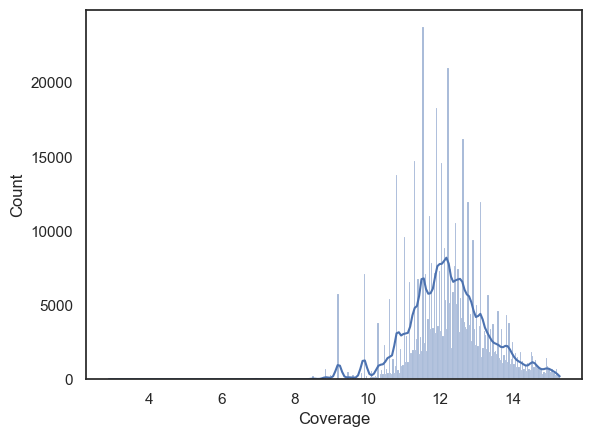

In [15]:
x=0.01
coverage=original_df["保险金额"]
coverage.name="Coverage"
coverage=coverage[coverage.between(coverage.quantile(x)+10,coverage.quantile(1-x))]
coverage=log(coverage)
sns.histplot(coverage,kde=True)

## 进一步分析

In [106]:
df["claimed"]=df["total_claim"].map(lambda x: 1 if x>0 else 0)
claims = smf.logit("claimed ~ log(Coverage)+Disaster*Post+Prem_before+Price", data=df[(df["Neighbor"]==0)]).fit()
rawsclaim = smf.logit("claimed ~ Disaster*Post", data=df[(df["Neighbor"]==0)]).fit()
stargazer = Stargazer([rawsclaim, claims])
# with open("../lib/table/claims.tex", "w") as f:
#     f.write(tablelize(stargazer))
stargazer
# claims.summary()

/Users/dcy/Desktop/thesis/.venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


Optimization terminated successfully.
         Current function value: 0.032284
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.035515
         Iterations 9


In [107]:
treated = df[df["Neighbor"]==0].copy()
treated["renew"]=treated["下年保单号"].map(lambda x: 1 if x else 0)
renew = smf.logit("renew ~ log(Coverage)+Disaster*Post+Prem_before+Price", data=treated).fit()
rawsrenew = smf.logit("renew  ~ Disaster*Post", data=treated).fit()
stargazer = Stargazer([rawsclaim,claims,rawsrenew, renew])
stargazer.custom_columns(['Claim', 'Claim', "Renew", "Renew"])
with open("../lib/table/renew.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer
# claims.summary()

Optimization terminated successfully.
         Current function value: 0.116458
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.154195
         Iterations 9


## 稳健性测试

In [17]:
def robust_test(category="Disaster", cond=False):
    df["treated"]=df[category]
    df["Quarter_before"] = df["maxpost"].map(
        lambda x: x // 90  if (x < 0 and x > -365) else None
    )
    df["Quarter_after"] = df["minpost"].map(
        lambda x: x // 90 if (x > 0 and x < 365) else None
    )
    if category == "Disaster":
        df["Quarter_before"] = df["Quarter_after"].fillna(
            (
                pd.to_datetime(df["maxraining_after"])
                - pd.to_datetime(df["保险起期"], unit="s")
            ).dt.days.map(lambda x: x // 90 if (x <= 365 and x >= 0) else None)
        )
        df["Quarter_after"] = df["Quarter_before"].fillna(
            -(
                pd.to_datetime(df["保险起期"], unit="s")
                - pd.to_datetime(df["maxraining_before"])
            ).dt.days.map(lambda x: x // 90  if (x <= 365 and x > 0) else None)
        )
    df["Quarter"] = df["Quarter_before"].fillna(df["Quarter_after"])
    y = -4 if category == "Disaster" else -3
    data = df[df["Quarter"].between(y, 0)].copy()
    reg_str = "log(Coverage) ~ treated*C(Quarter)"
    if cond:
        reg_str += "+Prem_before+Price+Area"
    model = smf.ols(
        reg_str,
        data=data,
    ).fit()
    robust=df[["Disaster","Neighbor", "Quarter", "Coverage"]]
    robust.to_parquet(f"../data/robust_{category}.parquet")
    return model


stargazer = Stargazer(
    [robust_test(i, j) for i in ["Disaster", "Neighbor"] for j in [False, True]]
)
# stargazer.custom_columns(["Disaster", "Disaster", "Neighbor", "Neighbor"])
# with open("../lib/table/robust.tex", "w") as f:
#     f.write(tablelize(stargazer))
stargazer

In [7]:
df.groupby(["Disaster", "Post"]).count()

total_claim   下年保单号  Neighbor     区站号    区站经度    区站纬度     保单号  \
Disaster Post                                                                  
0        0           68314   68314     68314   68314   68314   68314   68314   
         1          386793  386793    386793  386793  386793  386793  386793   
1        0           25343   25343     25343   25343   25343   25343   25343   
         1           41635   41635     41635   41635   41635   41635   41635   

                 保单经度    保单纬度  distance  ...  maxpost      省份      站名  \
Disaster Post                            ...                            
0        0      68314   68314     68314  ...    68314   68216   68216   
         1     386793  386793    386793  ...   386793  384236  384236   
1        0      25343   25343     25343  ...    25343   25343   25343   
         1      41635   41635     41635  ...    41635   41309   41309   

               Prem_before      ti   Claim  treated  Quarter_before  \
Disaster Post                                                         
0        0           68314   68314   68314    68314               0   
         1          386793  386793  386793   386793          315781   
1        0           25343   25343   25343    25343               0   
         1           41635   41635   41635    41635               0   

               Quarter_after  Quarter  
Disaster Post                          
0        0                 0        0  
         1            315877   315935  
1        0                 0        0  
         1                 0        0  

[4 rows x 36 columns]

## 异质性分析

In [17]:
# 分东中西部

hdf=df.copy()
east ={i:"East" for i in "北京、天津、河北、上海、江苏、浙江、福建、山东、广东、辽宁、海南".split("、")}
middle ={i:"Middle" for i in "山西、吉林、黑龙江、安徽、江西、河南、湖北、湖南".split("、")}
west ={i:"West" for i in "重庆、四川、内蒙古、广西、贵州、云南、西藏、陕西、甘肃、青海、宁夏、新疆".split("、")}
northeast ={i:"NorthEast" for i in "".split("、")}
provinces = {**east,**middle,**west,**northeast}
hdf["region"]=hdf["省份"].map(provinces)
stars = []
column = []
col=[]
for region, region_df in hdf.groupby("region"):
    column.append(region)
    col.append("Disaster")
    model = smf.ols("log(Coverage) ~ Disaster*Post", data=region_df[region_df["Neighbor"]==0]).fit()
    # model = smf.ols("log(Coverage) ~ Neighbor*Post", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer

In [5]:
# stars = []
# column = []
for region, region_df in hdf.groupby("region"):
    column.append(region)
    col.append("Neighbor")
    # model = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+Price+Area", data=region_df[region_df["Neighbor"]==0]).fit()
    model = smf.ols("log(Coverage) ~ Neighbor*Post", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
# stargazer.custom_columns(column, col)
stargazer.add_line("Region", column, "bt")
stargazer.add_line("Treated", col, "bt")
with open("../lib/table/het_geo.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

In [49]:
hdf=df.copy()
hdf = hdf[(hdf["t"]>2002)&(hdf["t"]<2013)]
stars = []
column = []
col = []
hdf["ti"]=hdf["t"].apply(lambda t: "2009-2013" if t>2008 else "2003-2008")
for region, region_df in hdf.groupby("ti"):
    column.append(region)
    col.append("Disaster")
    model = smf.ols("log(Coverage) ~ Disaster*Post+Prem_before+Price", data=region_df[region_df["Neighbor"]==0]).fit()
    # model = smf.ols("log(Coverage) ~ Neighbor*Post", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
# stargazer.custom_columns(column)
# with open("../lib/table/het_time_dis.tex", "w") as f:
#     f.write(tablelize(stargazer))
stargazer

In [50]:
# stars = []
# column = []
hdf["ti"]=hdf["t"].apply(lambda t: "2009-2013" if t>2009 else "2003-2008")
for region, region_df in hdf.groupby("ti"):
    column.append(region)
    col.append("Neighbor")
    # model = smf.ols("log(Coverage) ~ Disaster*Post", data=region_df[region_df["Neighbor"]==0]).fit()
    model = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+Price", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(column)
with open("../lib/table/het_time.tex", "w") as f:
    f.write(tablelize(stargazer))
stargazer

In [45]:
stars = []
column = []
for region, region_df in df.groupby("t"):
    column.append(region)
    # model = smf.ols("log(Coverage) ~ Disaster*Post", data=region_df[region_df["Neighbor"]==0]).fit()
    model = smf.ols("log(Coverage) ~ Neighbor*Post+Prem_before+Price", data=region_df[region_df["Disaster"]==0]).fit()
    stars.append(model)
stargazer = Stargazer(stars)
stargazer.custom_columns(column)
# with open("../lib/table/het_time.tex", "w") as f:
#     f.write(tablelize(stargazer))
stargazer

In [16]:
groups = "Coverage"
hdf = df[df[groups] > 0]
quantiles = hdf[groups].quantile([0.05, 0.35, 0.65, 0.95]).values.tolist()
hdf = hdf[hdf[groups].between(quantiles[0], quantiles[-1])]
stars = []

for category in ["Disaster", "Neighbor"]:
    for i in range(len(quantiles) - 1):
        noncat = "Neighbor" if category == "Disaster" else "Disaster"
        model = smf.ols(
            f"log(Coverage) ~ {category}*Post",
            data=hdf[
                (hdf[groups].between(quantiles[i], quantiles[i + 1]))
                & (hdf[noncat] == 0)
            ],
        ).fit()
        stars.append(model)
stargazer = Stargazer(stars)
stargazer

In [23]:
with open("../lib/table/het_cov.tex", "w") as f:
    f.write(tablelize(stargazer))